#

数据来自noaa的monthly， sst数据

- NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surface Temperature (OISST) Analysis, Version 2.1
  
## 官网获取下载地址：

-  https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html

In [24]:

"""
南印度洋海表温度锋面分析系统
Southern Indian Ocean SST Front Analysis System

Author: Ocean Front Analysis Team
Date: 2025-08-01
"""

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib import font_manager
import warnings
warnings.filterwarnings('ignore')

南印度洋SST锋面分析系统
Southern Indian Ocean SST Front Analysis System

[1/5] 初始化系统 Initializing system...
[2/5] 加载SST数据 Loading SST data...
[3/5] 计算梯度场 Calculating gradient field...
[4/5] 计算锋面指数 Calculating front indices...
[5/5] 生成图形 Generating figures...

分析完成 Analysis Complete!
------------------------------------------------------------
数据时间范围 Time range: 1982-01-01 to 2014-12-31
空间范围 Spatial range: (-50, -35)°N, (20, 100)°E
------------------------------------------------------------
指数统计 Index Statistics:
       strength_norm  position_norm
count   3.960000e+02   3.960000e+02
mean    5.921189e-16  -4.816537e-08
std     1.000000e+00   9.999997e-01
min    -2.369647e+00  -2.656162e+00
25%    -8.244794e-01  -6.685632e-01
50%    -4.277837e-02  -4.268348e-02
75%     8.183925e-01   6.853807e-01
max     2.618552e+00   3.083939e+00


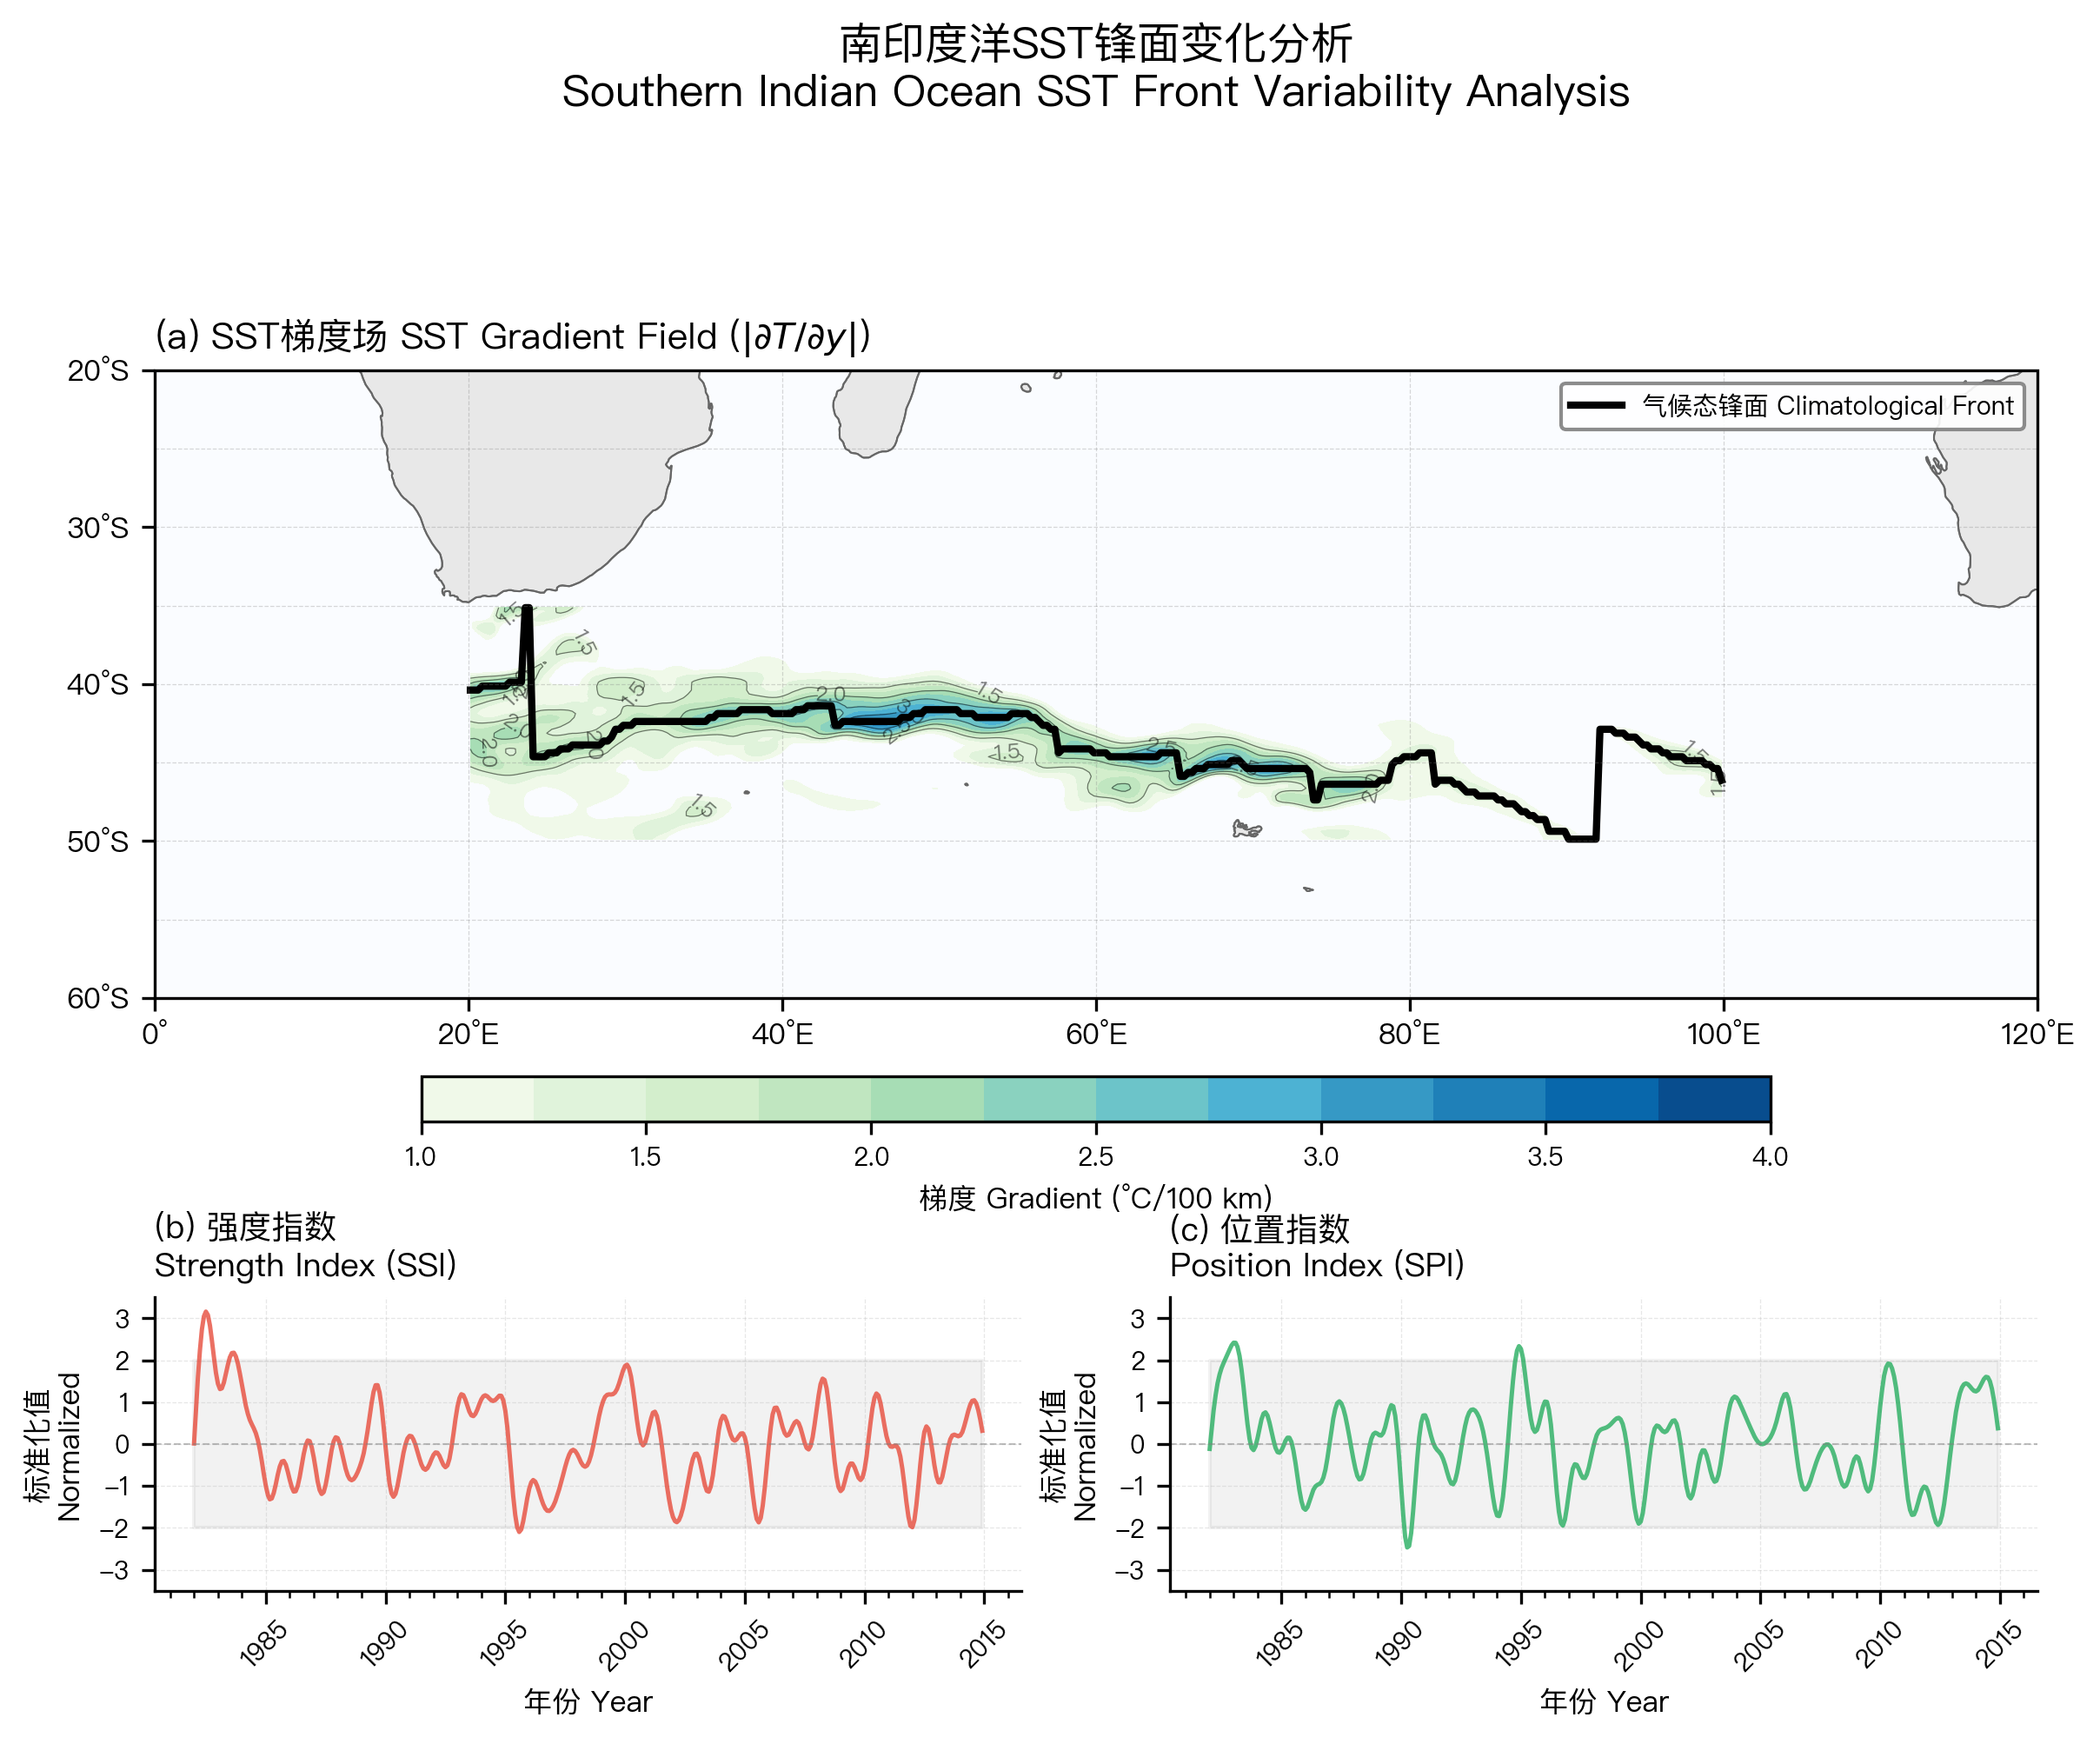

In [25]:

# ============== 数据处理类 Data Processing Class ==============
class SSTFrontAnalyzer:
    """SST锋面分析器 SST Front Analyzer"""
    
    def __init__(self, config=Config):
        """
        初始化分析器 Initialize analyzer
        
        Parameters:
            config: 配置类实例 Configuration class instance
        """
        self.config = config
        self.sst_data = None
        self.gradient = None
        self.indices = None
        
    def load_data(self, filepath=None):
        """
        加载SST数据 Load SST data
        
        Parameters:
            filepath: 数据文件路径 Data file path
        
        Returns:
            xr.Dataset: 处理后的SST数据 Processed SST data
        """
        filepath = filepath or self.config.DATA_PATH
        
        # 读取并重组数据 Read and reorganize data
        ds = xr.open_dataset(filepath)
        ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'} if 'lat' in ds.dims else {})
        ds = ds.transpose("time", "latitude", "longitude")
        
        # 提取指定时空范围 Extract specified spatiotemporal range
        self.sst_data = ds["sst"].sel(
            time=slice(*self.config.TIME_RANGE),
            latitude=slice(*self.config.LAT_BOUNDS),
            longitude=slice(*self.config.LON_BOUNDS)
        )
        
        return self.sst_data
    
    def calculate_gradient(self, data=None):
        """
        计算SST梯度 Calculate SST gradient
        
        Parameters:
            data: SST数据 SST data (optional)
        
        Returns:
            xr.DataArray: SST梯度场 SST gradient field (°C/100km)
        """
        data = data if data is not None else self.sst_data
        
        # 计算纬向网格间距 Calculate meridional grid spacing
        dlat = np.abs(np.gradient(data.latitude.values)[0]) * np.pi / 180
        dy = self.config.EARTH_RADIUS * dlat
        
        # 计算梯度并转换单位 Calculate gradient and convert units
        self.gradient = np.abs(
            data.differentiate('latitude') / (4 * dy) * self.config.GRADIENT_SCALE
        )
        
        return self.gradient
    
    def identify_front(self, gradient=None):
        """
        识别锋面位置 Identify front position
        
        Parameters:
            gradient: 梯度场 Gradient field (optional)
        
        Returns:
            tuple: (气候态锋面纬度, 阈值) (Climatological front latitude, threshold)
        """
        gradient = gradient if gradient is not None else self.gradient
        
        # 计算气候态梯度 Calculate climatological gradient
        gradient_mean = gradient.mean('time')
        threshold = gradient_mean.quantile(self.config.THRESHOLD_QUANTILE)
        
        # 识别最大梯度位置 Identify maximum gradient position
        front_indices = gradient_mean.argmax(dim='latitude')
        front_latitudes = gradient_mean['latitude'][front_indices].values
        
        return front_latitudes, threshold.item()
    
    def calculate_indices(self):
        """
        计算锋面强度和位置指数 Calculate front intensity and position indices
        
        Returns:
            pd.DataFrame: 包含时间序列指数的数据框 DataFrame with time series indices
        """
        if self.gradient is None:
            self.calculate_gradient()
        
        # 获取气候态锋面位置 Get climatological front position
        clim_front_lats, _ = self.identify_front()
        
        # 计算强度指数(加权平均) Calculate intensity index (weighted average)
        weights = np.cos(np.deg2rad(self.gradient.latitude))
        strength_index = (
            (self.gradient * weights).mean(['longitude', 'latitude']) / 
            weights.mean()
        ).values
        
        # 计算位置指数 Calculate position index
        front_indices = self.gradient.argmax(dim='latitude').compute()
        front_lats = self.gradient.latitude[front_indices].values
        position_index = [
            np.mean(front_lats[i] - clim_front_lats) 
            for i in range(len(front_lats))
        ]
        
        # 创建数据框 Create DataFrame
        self.indices = pd.DataFrame({
            'time': self.gradient.time.values,
            'strength': strength_index,
            'position': position_index
        })
        
        # 标准化 Standardization
        for col in ['strength', 'position']:
            mean, std = self.indices[col].mean(), self.indices[col].std()
            self.indices[f'{col}_norm'] = (self.indices[col] - mean) / std
        
        return self.indices

# ============== 时间序列处理类 Time Series Processing Class ==============
class TimeSeriesProcessor:
    """时间序列处理器 Time Series Processor"""
    
    @staticmethod
    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        """
        带通滤波 Bandpass filter
        
        Parameters:
            data: 输入数据 Input data
            lowcut: 低频截止 Low frequency cutoff
            highcut: 高频截止 High frequency cutoff
            fs: 采样频率 Sampling frequency
            order: 滤波器阶数 Filter order
        
        Returns:
            np.ndarray: 滤波后数据 Filtered data
        """
        nyquist = 0.5 * fs
        b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
        return filtfilt(b, a, data, axis=0)
    
    @staticmethod
    def detrend(data):
        """
        去除线性趋势 Remove linear trend
        
        Parameters:
            data: 输入数据 Input data
        
        Returns:
            np.ndarray: 去趋势数据 Detrended data
        """
        x = np.arange(len(data))
        p = np.polyfit(x, data, 1)
        return data - np.polyval(p, x)
    
    @classmethod
    def process_series(cls, data, name, config=Config):
        """
        完整处理时间序列 Complete time series processing
        
        Parameters:
            data: xr.DataArray 时间序列数据 Time series data
            name: str 变量名称 Variable name
            config: 配置类 Configuration class
        
        Returns:
            xr.DataArray: 处理后的标准化数据 Processed standardized data
        """
        # 去趋势 Detrend
        detrended = cls.detrend(data.values)
        
        # 创建DataArray
        da = xr.DataArray(detrended, coords=data.coords, dims=data.dims)
        
        # 去季节性 Remove seasonality
        monthly_clim = da.groupby('time.month').mean('time')
        deseasonalized = da.groupby('time.month') - monthly_clim
        
        # 带通滤波 Bandpass filter
        filtered = cls.bandpass_filter(
            deseasonalized.values,
            config.FILTER_LOWCUT,
            config.FILTER_HIGHCUT,
            config.SAMPLING_FREQ
        )
        
        # 创建结果DataArray Create result DataArray
        result = xr.DataArray(
            filtered.astype(np.float32),
            coords=deseasonalized.coords,
            dims=deseasonalized.dims,
            name=name
        ).sel(time=slice(*config.ANALYSIS_RANGE))
        
        # 标准化 Standardization
        return (result - result.mean()) / result.std()

# ============== 绘图类 Plotting Class ==============
class FrontPlotter:
    """锋面绘图器 Front Plotter"""
    
    def __init__(self, config=Config):
        """初始化绘图器 Initialize plotter"""
        self.config = config
        self._setup_style()
    
    def _setup_style(self):
        """设置绘图样式 Setup plotting style"""
        # 设置中英文字体 Setup Chinese and English fonts
        plt.rcParams.update({
            'font.family': ['DejaVu Sans', 'Arial'],
            'font.size': 10,
            'axes.labelsize': 9,
            'axes.titlesize': 11,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'legend.fontsize': 8,
            'figure.dpi': self.config.FIG_DPI,
            'axes.linewidth': 0.8,
            'axes.grid': False,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'lines.linewidth': 1.2,
            'grid.alpha': 0.3,
            'grid.linewidth': 0.5,
        })
        plt.rcParams['font.family']=['PingFang HK']
        plt.rcParams['axes.unicode_minus']=False

    def create_composite_figure(self, analyzer, indices_processed):
        """
        创建组合图 Create composite figure
        
        Parameters:
            analyzer: SSTFrontAnalyzer实例 SSTFrontAnalyzer instance
            indices_processed: dict 处理后的指数 Processed indices
        
        Returns:
            matplotlib.figure.Figure: 图形对象 Figure object
        """
        # 创建图形 Create figure
        fig = plt.figure(figsize=self.config.FIG_SIZE, dpi=self.config.FIG_DPI)
        
        # ========== 主图：梯度场分布 Main plot: Gradient field ==========
        ax_main = fig.add_axes([0.12, 0.42, 0.76, 0.50], projection=ccrs.PlateCarree())
        
        # 计算绘图数据 Calculate plotting data
        gradient_mean = analyzer.gradient.sel(
            latitude=slice(*self.config.PLOT_LAT),
            longitude=slice(*self.config.PLOT_LON)
        ).mean('time')
        
        # 绘制梯度场 Plot gradient field
        self._plot_gradient_field(ax_main, gradient_mean, analyzer)
        
        # ========== 子图1：强度指数 Subplot 1: Strength index ==========
        ax_strength = fig.add_axes([0.12, 0.18, 0.35, 0.15])
        self._plot_time_series(
            ax_strength, 
            indices_processed['strength'],
            color='#E74C3C',
            title='(b) 强度指数\nStrength Index (SSI)',
            ylabel='标准化值\nNormalized'
        )
        
        # ========== 子图2：位置指数 Subplot 2: Position index ==========
        ax_position = fig.add_axes([0.53, 0.18, 0.35, 0.15])
        self._plot_time_series(
            ax_position,
            indices_processed['position'],
            color='#27AE60',
            title='(c) 位置指数\nPosition Index (SPI)',
            ylabel='标准化值\nNormalized'
        )
        
        # 添加总标题 Add main title
        fig.suptitle(
            '南印度洋SST锋面变化分析\nSouthern Indian Ocean SST Front Variability Analysis',
            fontsize=12,
            fontweight='bold',
            y=0.98
        )
        
        return fig
    
    def _plot_gradient_field(self, ax, gradient_mean, analyzer):
        """绘制梯度场 Plot gradient field"""
        # 添加地理特征 Add geographic features
        ax.add_feature(cfeature.LAND, facecolor='#E8E8E8', edgecolor='#666666', linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor='#F0F8FF', alpha=0.3)
        ax.coastlines(resolution='50m', color='#666666', linewidth=0.5)
        
        # 绘制梯度等值线填充 Plot gradient contour fill
        cf = ax.contourf(
            gradient_mean.longitude,
            gradient_mean.latitude,
            gradient_mean,
            levels=self.config.GRADIENT_LEVELS,
            cmap='GnBu',
            extend='neither',
            transform=ccrs.PlateCarree()
        )
        
        # 添加等值线 Add contour lines
        cs = ax.contour(
            gradient_mean.longitude,
            gradient_mean.latitude,
            gradient_mean,
            levels=[1.5, 2.0, 2.5, 3.0, 3.5],
            colors='black',
            linewidths=0.3,
            alpha=0.5,
            transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, inline=True, fontsize=6, fmt='%.1f')
        
        # 标记锋面位置 Mark front position
        front_lats, threshold = analyzer.identify_front()
        ax.plot(
            gradient_mean.longitude,
            front_lats,
            'k-',
            linewidth=2,
            label='气候态锋面 Climatological Front',
            transform=ccrs.PlateCarree()
        )
        
        # 设置地图范围和标签 Set map extent and labels
        ax.set_extent([*self.config.PLOT_LON, *self.config.PLOT_LAT], crs=ccrs.PlateCarree())
        
        # 设置坐标轴 Set axes
        ax.set_xticks(np.arange(0, 131, 20), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(-60, -19, 10), crs=ccrs.PlateCarree())
        ax.set_xticklabels([f'{x}°E' if x > 0 else '0°' for x in np.arange(0, 131, 20)])
        ax.set_yticklabels([f'{abs(y)}°S' for y in np.arange(-60, -19, 10)])
        
        # 添加网格 Add grid
        gl = ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', 
                         alpha=0.3, linestyle='--')
        
        # 标题 Title
        ax.set_title(
            r'(a) SST梯度场 SST Gradient Field ($|\partial T/\partial y|$)',
            loc='left',
            fontweight='bold',
            fontsize=10
        )
        
        # 颜色条 Colorbar
        cbar = plt.colorbar(cf, ax=ax, orientation='horizontal',
                           fraction=0.046, pad=0.08, aspect=30)
        cbar.set_label('梯度 Gradient (°C/100 km)', fontsize=8)
        cbar.ax.tick_params(labelsize=7)
        
        # 图例 Legend
        ax.legend(loc='upper right', fontsize=7, framealpha=0.9,
                 edgecolor='gray', fancybox=True)
    
    def _plot_time_series(self, ax, data, color, title, ylabel):
        """绘制时间序列 Plot time series"""
        # 绘制数据 Plot data
        time = pd.to_datetime(data.time.values)
        ax.plot(time, data.values, color=color, linewidth=1.2, alpha=0.8)
        
        # 添加零线 Add zero line
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # 添加±2σ区域 Add ±2σ region
        ax.fill_between(time, -2, 2, color='gray', alpha=0.1)
        
        # 设置范围和刻度 Set range and ticks
        ax.set_ylim(-3.5, 3.5)
        ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
        
        # 设置x轴日期格式 Set x-axis date format
        import matplotlib.dates as mdates
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(1))
        
        # 标签和标题 Labels and title
        ax.set_xlabel('年份 Year', fontsize=8)
        ax.set_ylabel(ylabel, fontsize=8)
        ax.set_title(title, loc='left', fontweight='bold', fontsize=9)
        
        # 网格 Grid
        ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
       

# ============== 主程序 Main Program ==============
def main():
    """主函数 Main function"""
    
    print("="*60)
    print("南印度洋SST锋面分析系统")
    print("Southern Indian Ocean SST Front Analysis System")
    print("="*60)
    
    # 1. 初始化分析器 Initialize analyzer
    print("\n[1/5] 初始化系统 Initializing system...")
    config = Config()
    analyzer = SSTFrontAnalyzer(config)
    processor = TimeSeriesProcessor()
    plotter = FrontPlotter(config)
    
    # 2. 加载数据 Load data
    print("[2/5] 加载SST数据 Loading SST data...")
    analyzer.load_data()
    
    # 3. 计算梯度 Calculate gradient
    print("[3/5] 计算梯度场 Calculating gradient field...")
    analyzer.calculate_gradient()
    
    # 4. 计算指数 Calculate indices
    print("[4/5] 计算锋面指数 Calculating front indices...")
    indices = analyzer.calculate_indices()
    
    # 处理时间序列 Process time series
    indices_processed = {}
    for col in ['strength', 'position']:
        da = xr.DataArray(
            indices[col].values,
            dims='time',
            coords={'time': indices['time']}
        )
        indices_processed[col] = processor.process_series(da, col, config)
    
    # 5. 绘图 Plotting
    print("[5/5] 生成图形 Generating figures...")
    fig = plotter.create_composite_figure(analyzer, indices_processed)
    
    # 保存结果 Save results
    fig.savefig('sst_front_analysis.png', dpi=config.FIG_DPI, bbox_inches='tight')
    indices.to_csv('front_indices.csv', index=False)
    
    # 保存处理后的指数 Save processed indices
    for name, data in indices_processed.items():
        data.to_netcdf(f'{name}_index_processed.nc')
    
    # 输出统计信息 Output statistics
    print("\n" + "="*60)
    print("分析完成 Analysis Complete!")
    print("-"*60)
    print(f"数据时间范围 Time range: {config.TIME_RANGE[0]} to {config.TIME_RANGE[1]}")
    print(f"空间范围 Spatial range: {config.LAT_BOUNDS}°N, {config.LON_BOUNDS}°E")
    print("-"*60)
    print("指数统计 Index Statistics:")
    print(indices[['strength_norm', 'position_norm']].describe())
    print("="*60)
    
    plt.show()
    
    return analyzer, indices, indices_processed




# ============== 配置类 Configuration Class ==============
class Config:
    """配置参数类 Configuration Parameters"""
    
    # 数据参数 Data Parameters
    DATA_PATH = "../data/sst.mon.mean.nc"
    TIME_RANGE = ('1982-01-01', '2014-12-31')
    ANALYSIS_RANGE = ('1979-01-01', '2014-12-31')
    
    # 空间范围 Spatial Range
    LAT_BOUNDS = (-50, -35)  # 纬度范围 Latitude range
    LON_BOUNDS = (20, 100)   # 经度范围 Longitude range
    
    # 绘图范围 Plotting Range
    PLOT_LAT = (-50, -35)
    PLOT_LON = (20, 100)
    
    # 滤波参数 Filter Parameters
    FILTER_LOWCUT = 1/10     # 低频截止 Low frequency cutoff
    FILTER_HIGHCUT = 1/1.0001  # 高频截止 High frequency cutoff
    SAMPLING_FREQ = 12       # 采样频率(月) Sampling frequency (monthly)
    
    # 地球参数 Earth Parameters
    EARTH_RADIUS = 6371000   # 地球半径(米) Earth radius (m)
    
    # 梯度参数 Gradient Parameters
    GRADIENT_SCALE = 1e5     # 梯度缩放因子 Gradient scale factor (for °C/100km)
    THRESHOLD_QUANTILE = 0.5 # 阈值分位数 Threshold quantile
    
    # 图形参数 Figure Parameters
    FIG_DPI = 300
    FIG_SIZE = (9.5, 7.5)
    COLORMAP = 'RdBu_r'
    GRADIENT_LEVELS = np.linspace(1, 4, 13)

if __name__ == "__main__":
    analyzer, indices, indices_processed = main()